
<br>
<br>

#  WNV Prediction with Logistic Regression - Jennifer Siwu
<br>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import pearsonr
from datetime import datetime
import pingouin as pg
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [142]:
master_database=pd.read_csv("/Users/jenniferwu/Documents/kaggle-competition1/cleaned_data/train_spray_weather_v1.csv",float_precision='round_trip')

In [143]:
codesum = master_database[['BCFG', 'BR',
       'DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
       'TS', 'TSRA', 'VCFG', 'VCTS','WnvPresent']]

In [144]:
bar1 = master_database[master_database.WnvPresent == 0][['BCFG', 'BR',
       'DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
       'TS', 'TSRA', 'VCFG', 'VCTS']].sum()
bar2 = master_database[master_database.WnvPresent == 1][['BCFG', 'BR',
       'DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
       'TS', 'TSRA', 'VCFG', 'VCTS']].sum()

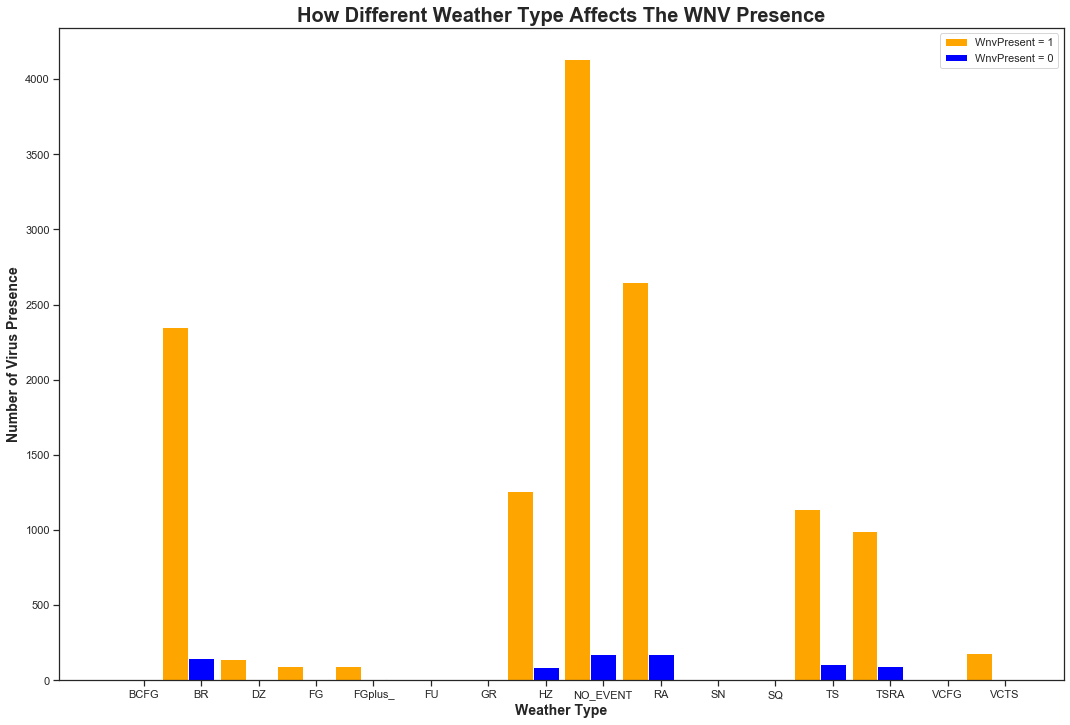

In [145]:
barWidth = 0.45 
# set height of bar
bars1 = bar1
bars2 = bar2
lab = ['BCFG', 'BR',
       'DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
       'TS', 'TSRA', 'VCFG', 'VCTS','WnvPresent']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
f, ax = plt.subplots(figsize=(18,12))
plt.bar(r1, bars1, color='orange', width=barWidth, edgecolor='white', label='WnvPresent = 1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='WnvPresent = 0')
 
# Add xticks on the middle of the group bars
plt.xlabel('Weather Type', fontweight='bold', size = 14)
plt.ylabel('Number of Virus Presence', fontweight='bold', size = 14)

# Create labels
label = round(bar1,1)
label2 = round(bar2,1)


plt.xticks([r + barWidth for r in range(len(bars1))], bars1.index)
plt.title('How Different Weather Type Affects The WNV Presence', size = 20, fontweight='bold')

 
# Create legend & Show graphic
plt.legend()
plt.show()

In [146]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scs.chi2_contingency(ctsum.fillna(0)))

In [147]:
variable = []
Chi_Squared_Val = []
P_Value = []

for col in codesum.columns[:-1]:
    variable.append(col)
    Chi_Squared_Val.append(chisq_of_df_cols(codesum, col,'WnvPresent')[0])
    P_Value.append(round(chisq_of_df_cols(codesum, col,'WnvPresent')[1],3))

    

chi_square_df = pd.DataFrame({'Variable Name':variable,
             'Chi Squared Value':Chi_Squared_Val,
             'P-value':P_Value})

In [148]:
print('Based on Test, we can drop :',list(chi_square_df['Variable Name'][chi_square_df['P-value'] > .05]))
chi_square_df

Based on Test, we can drop : ['BCFG', 'BR', 'FG', 'FGplus_', 'FU', 'GR', 'SN', 'SQ', 'VCFG']


,Variable Name,Chi Squared Value,P-value
0,BCFG,0.000000,1.000
1,BR,2.223051,0.136
2,DZ,5.414004,0.020
3,FG,1.569441,0.210
4,FGplus_,1.569441,0.210
5,FU,0.000000,1.000
6,GR,0.000000,1.000
7,HZ,6.091725,0.014
8,NO_EVENT,26.173037,0.000
9,RA,5.411191,0.020


## Building the Model with All Variables 

In [150]:
master_database.drop(['AddressNumberAndStreet','Address','AddressAccuracy','NumMosquitos','Date','Street','Block','CodeSum_Station'], axis = 1, inplace = True)

##### Adding length of day column to replace sunrise and sunset columns

In [151]:
master_database['Sunrise_Station'] = pd.to_datetime(master_database['Sunrise_Station'],format='%H:%M:%S')
master_database['Sunset_Station'] = pd.to_datetime(master_database['Sunset_Station'], format='%H:%M:%S')
master_database['length_of_day']=(master_database['Sunset_Station'] - master_database['Sunrise_Station']).dt.total_seconds()
master_database['length_of_day']=master_database['length_of_day'].astype(int)
master_database = master_database.drop(['Sunrise_Station', 'Sunset_Station'], axis=1)

In [152]:
master_database_dodo = pd.get_dummies(master_database, columns=['Species'], prefix = [''])
l = (len(list(master_database_dodo.columns))-len(master_database.Species.value_counts()))
master_database = pd.concat([master_database,master_database_dodo.iloc[:,l:]],axis=1)
master_database.drop('Species',axis =1 , inplace = True)

In [153]:
master_database_dodo = pd.get_dummies(master_database, columns=['Trap'], prefix = [''])
l = (len(list(master_database_dodo.columns))-len(master_database.Trap.value_counts()))
master_database = pd.concat([master_database,master_database_dodo.iloc[:,l:]],axis=1)
master_database.drop('Trap',axis =1 , inplace = True)

In [154]:
master_database.columns

Index(['Latitude', 'Longitude', 'WnvPresent', 'year', 'month', 'day',
       'dist_2011-08-29 00:00:00', 'dist_2011-09-07 00:00:00',
       'dist_2013-07-17 00:00:00', 'dist_2013-07-25 00:00:00',
       ...
       '_T230', '_T231', '_T232', '_T233', '_T235', '_T236', '_T237', '_T238',
       '_T900', '_T903'],
      dtype='object', length=208)

WnvPresent
0    8153
1     457
Name: WnvPresent, dtype: int64


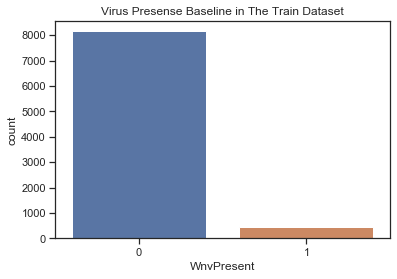

In [155]:
#Baseline
sns.countplot(x = 'WnvPresent', data=master_database)
plt.title('Virus Presense Baseline in The Train Dataset')
print("WnvPresent",master_database.WnvPresent.value_counts(), sep='\n')

In [156]:
master_database.WnvPresent.value_counts()/len(master_database.WnvPresent)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

In [157]:
df = pd.DataFrame()
df['WnvPresence'] = [0,1]
df['pct'] = master_database.WnvPresent.value_counts()/len(master_database.WnvPresent)

WnvPresent = 1 is 5.31 %
WnvPresent = 0 is 94.69 %


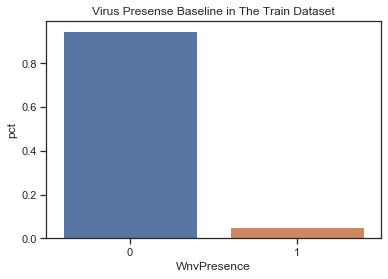

In [158]:
df
sns.barplot(x='WnvPresence',y='pct',data=df)
plt.title('Virus Presense Baseline in The Train Dataset')
print("WnvPresent = 1 is",round(df.pct[1]*100,2),'%')
print("WnvPresent = 0 is",round(df.pct[0]*100,2),'%')

# Splitting Test and Train Data

In [159]:
split = np.random.rand(len(master_database)) < 0.7
train = master_database[split]
test = master_database[~split]

In [209]:
print("train data breakdown :",train.WnvPresent.value_counts()/(len(train.WnvPresent)+1),' ',sep='\n')
print("test data breakdown :",test.WnvPresent.value_counts()/(len(test.WnvPresent)+1),sep='\n')

train data breakdown :
0    0.945437
1    0.054398
Name: WnvPresent, dtype: float64
 
test data breakdown :
0    0.949688
1    0.049922
Name: WnvPresent, dtype: float64


# Model 1

In [217]:
X_train1 = train.loc[:, train.columns != 'WnvPresent']
y_train1 = train.loc[:, train.columns == 'WnvPresent']
X_test1 = test.loc[:, test.columns != 'WnvPresent']
y_test1 = test.loc[:, test.columns == 'WnvPresent']

In [218]:
X_train = X_train1.values
X_train=X_train1.astype('int64')
y_train= y_train1.values


X_test = X_test1.values
X_test=X_test1.astype('int64')
y_test= y_test1.values

In [219]:

# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [220]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[2435,    0],
       [ 128,    0]])

In [221]:
def heatMap(df):
    #Create Correlation df
    corr = df
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(10, 220, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)+1), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)+1), corr.columns)
    plt.title("Confusion Matrix", size = 20)
    #show plot
    plt.show()

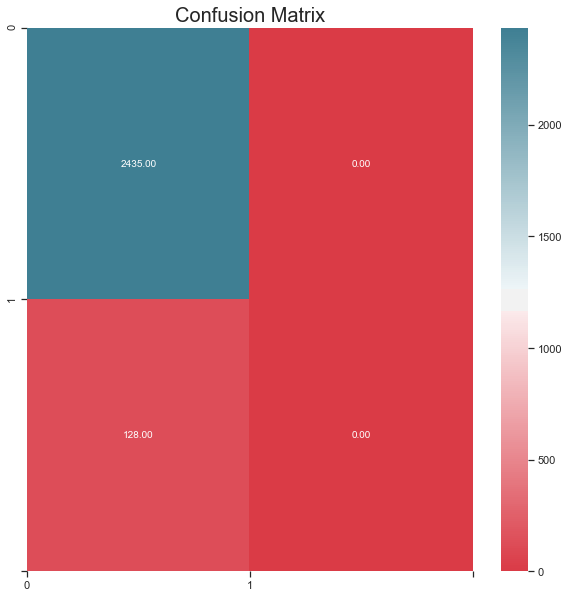

In [222]:
heatMap(pd.DataFrame(cnf_matrix))

In [223]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9500585251658213
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


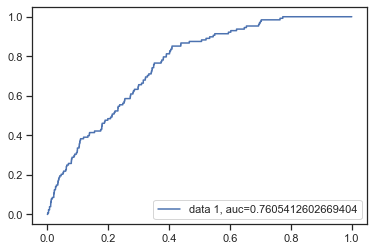

In [224]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Model 2 - Dropped Some CodeSum Variables
### Result : Model performance remained the same since the data is imbalance

In [239]:
train1 = train.drop(columns=['BCFG', 'BR', 'FG', 'FGplus_', 'FU', 'GR', 'SN', 'SQ', 'VCFG'])
test1 = test.drop(columns=['BCFG', 'BR', 'FG', 'FGplus_', 'FU', 'GR', 'SN', 'SQ', 'VCFG'])

In [240]:
X_train = train1.loc[:, train1.columns != 'WnvPresent']
y_train = train1.loc[:, train1.columns == 'WnvPresent']
X_test = test1.loc[:, test1.columns != 'WnvPresent']
y_test = test1.loc[:, test1.columns == 'WnvPresent']

In [241]:
X_train = X_train.values
X_train=X_train.astype('int64')
y_train= y_train.values


X_test = X_test.values
X_test=X_test.astype('int64')
y_test= y_test.values

In [242]:

# instantiate the model (using the default parameters)
logreg2 = LogisticRegression()
logreg2.fit(X_train,y_train)
y_pred2=logreg2.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [243]:

cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
cnf_matrix2

array([[2435,    0],
       [ 128,    0]])

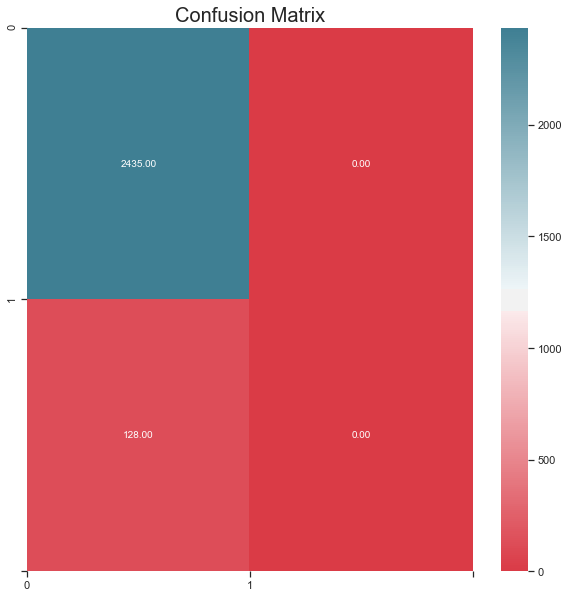

In [244]:
heatMap(pd.DataFrame(cnf_matrix2))

In [245]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9500585251658213
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


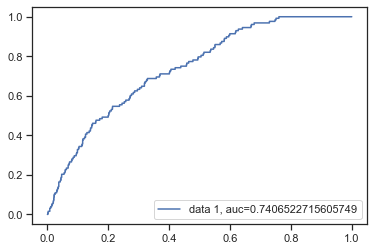

In [246]:
y_pred_proba = logreg2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# SMOTE 
Synthetic Minority Over Sampling Technique.
What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

In [263]:
X_train = train.loc[:, train.columns != 'WnvPresent']
y_train = train.loc[:, train.columns == 'WnvPresent']
X_test = test.loc[:, test.columns != 'WnvPresent']
y_test = test.loc[:, test.columns == 'WnvPresent']


X_train = X_train.values
X_train=X_train.astype('int64')
y_train= y_train.values


X_test = X_test.values
X_test=X_test.astype('int64')
y_test= y_test.values

In [278]:
smt = SMOTE()
X_trainsmt, y_trainsmt = smt.fit_sample(X_train, y_train)
#X_testsmt, y_testsmt = smt.fit_sample(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


bincount : [5718 5718]


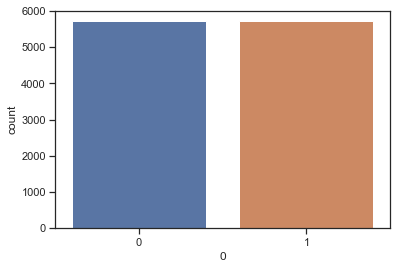

In [279]:
sns.countplot(x = 0, data=pd.DataFrame(y_trainsmt))
print("bincount :",np.bincount(y_trainsmt))

# Model 3 - Smoted train and test with all independent vars

In [281]:

# instantiate the model (using the default parameters)
logreg3 = LogisticRegression()
logreg3.fit(X_trainsmt,y_trainsmt)
y_pred3=logreg3.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[2397   38]
 [ 120    8]]


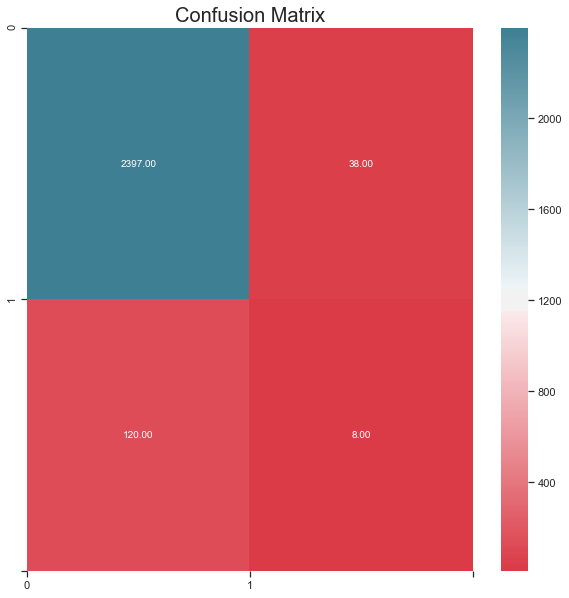

Accuracy: 0.9383534920015607
Precision: 0.17391304347826086
Recall: 0.0625


In [282]:
cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred3)
print(cnf_matrix2)

heatMap(pd.DataFrame(cnf_matrix2))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))
print("Precision:",metrics.precision_score(y_test, y_pred3))
print("Recall:",metrics.recall_score(y_test, y_pred3))
